# Defining the Problem


### We will be checking x-ray images of lungs and classifying them, with the help of computer vision modeling techniques, as either having pneumonia or being normal. Since this is a healthcare problem it is always best to let the model overpredict. We need to predict with the highest form of accuracy and should have nearly 100% recall if possible, with a high precision score as well. We need to be sure to diagnose any possible case of infection and not misclassify an infected lung as healthy because of small margins. Softmax logits can often be used to determine the prediction rather than a softmax function deciding the class. This is a critical decision based on experience with the data as well as the behavior of the model.

## Data

### In this problem set, we use open source data, which can be found at https://www.kaggle.com/tolgadincer/labeled-chest-xray-images

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [01:04<00:00, 18.5MB/s]
100% 1.17G/1.17G [01:04<00:00, 19.6MB/s]


In [ ]:
!unzip /content/labeled-chest-xray-images.zip

## Libraries

In [8]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

## Data Exploration

In [9]:
class_name = ['NORMAL','PNEUMONIA']

def get_list_files(dirName):
  files_list = os.listdir(dirName)
  return files_list

data_path = '/content/chest_xray'

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [12]:
# We are hard-coding the class names to be NORMAL and PNEUMONIA since
# the folders are arranged in that fashion.

print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


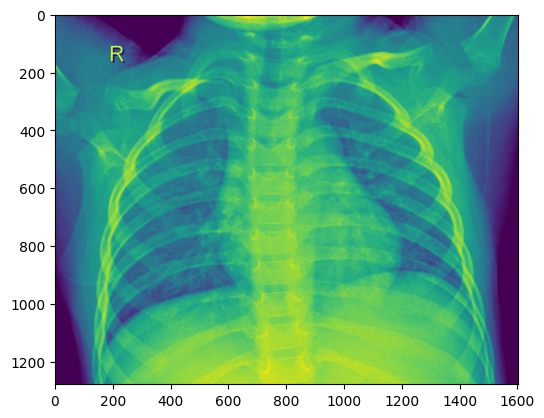

############################################
############################################
############################################
shape of image is:  (1279, 1604)


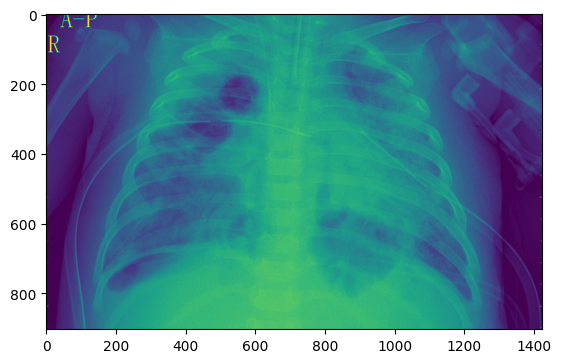

############################################
############################################
############################################
shape of image is:  (904, 1424)


In [19]:
# Random image check
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img_path_normal = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
img_path_pneumonia = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[rand_img_no]


#display(Image.open(img,'r'),)
img = mpimg.imread(img_path_normal)
imgplot = plt.imshow(img)
plt.show()
print('############################################')
print('############################################')
print('############################################')
print('shape of image is: ',img.shape)


#display(Image.open(img,'r'),)
img = mpimg.imread(img_path_pneumonia)
imgplot = plt.imshow(img)
plt.show()
print('############################################')
print('############################################')
print('############################################')
print('shape of image is: ',img.shape)

## Data Loader

In [21]:
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 16,
                          shuffle= True,
                          pin_memory= True)

test_loader = DataLoader(test_data,
                         batch_size= 1,
                         shuffle= False,
                         pin_memory= True)

class_names = train_data.classes
print('class_names: ',class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

class_names:  ['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## Define the Model

In [30]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # Input Block
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                              out_channels=8,
                                              kernel_size=(3, 3),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(4)
                                              )

    self.pool11 = nn.MaxPool2d(2, 2)
    # CONVOLUTION BLOCK
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8,
                                              out_channels=16,
                                              kernel_size=(3, 3),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(16)
                                              )


    # TRANSITION BLOCK
    self.pool22 = nn.MaxPool2d(2, 2)
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16,
                                              out_channels=10,
                                              kernel_size=(1, 1),
                                              padding=0,
                                              bias=False),
                                              #nn.BatchNorm2d(10),
                                              nn.ReLU()
                                              )
    self.pool33 = nn.MaxPool2d(2, 2)
    # CONVOLUTION BLOCK
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10,
                                              out_channels=10,
                                              kernel_size=(3, 3),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(10)
                                              )

    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=10,
                                              out_channels=32,
                                              kernel_size=(1, 1),
                                              padding=0,
                                              bias=False),
                                              #nn.BatchNorm2d(32),
                                              nn.ReLU(),
                                              )

    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=32,
                                              out_channels=10,
                                              kernel_size=(1, 1),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(10),
                                              )

    self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10,
                                              out_channels=10,
                                              kernel_size=(3, 3),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(10)
                                              )

    self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                              out_channels=32,
                                              kernel_size=(1, 1),
                                              padding=0,
                                              bias=False),
                                              #nn.BatchNorm2d(32),
                                              nn.ReLU()
                                              )

    self.convblock9 = nn.Sequential(nn.Conv2d(in_channels=32,
                                              out_channels=10,
                                              kernel_size=(1, 1),
                                              padding=0,
                                              bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(10),
                                              )


    self.convblock10 = nn.Sequential(nn.Conv2d(in_channels=10,
                                               out_channels=14,
                                               kernel_size=(3, 3),
                                               padding=0,
                                               bias=False),
                                              nn.ReLU(),
                                              #nn.BatchNorm2d(14),
                                              )

    self.convblock11 = nn.Sequential(nn.Conv2d(in_channels=14,
                                               out_channels=16,
                                               kernel_size=(3, 3),
                                               padding=0,
                                               bias=False),
                                               nn.ReLU(),
                                               #nn.BatchNorm2d(16),
                                               )
# OUTPUT BLOCK
    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=4))
    self.convblockout = nn.Sequential(nn.Conv2d(in_channels=16,
                                                out_channels=2,
                                                kernel_size=(4, 4),
                                                padding=0,
                                                bias=False),)

  def forward(self, x):
    x = self.convblock1(x)
    x = self.pool11(x)
    x = self.convblock2(x)
    x = self.pool22(x)
    x = self.convblock3(x)
    x = self.pool33(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = self.convblock8(x)
    x = self.convblock9(x)
    x = self.convblock10(x)
    x = self.convblock11(x)
    x = self.gap(x)
    x = self.convblockout(x)
    x = x.view(-1, 2)
    return F.log_softmax(x, dim=-1)

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Con

## The Training Process


In [32]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get data
    data, target = data.to(device), target.to(device)
    # Initialization of gradient
    optimizer.zero_grad()
    ## prediction on data
    y_pred = model(data)
    # Calculating loss given the prediction
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    # Backprop
    loss.backward()
    optimizer.step()
    # get the index of the log-probability corresponding to the max value
    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss,
                                                                              correct,
                                                                              len(test_loader.dataset),
                                                                              100. * correct / len(test_loader.dataset)))
  test_acc.append(100. * correct / len(test_loader.dataset))

In [33]:
model = Net().to(device)

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            momentum=0.9)

scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15

for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  print('current Learning Rate: ',
        optimizer.state_dict()["param_groups"][0]["lr"])
  test(model, device, test_loader)

EPOCH: 0


Loss=0.6931483745574951 Batch_id=326 Accuracy=25.88: 100%|██████████| 327/327 [01:33<00:00,  3.48it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 231/624 (37.02%)

EPOCH: 1


Loss=0.6931477785110474 Batch_id=326 Accuracy=25.90: 100%|██████████| 327/327 [01:34<00:00,  3.46it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 230/624 (36.86%)

EPOCH: 2


Loss=0.6931479573249817 Batch_id=326 Accuracy=25.94: 100%|██████████| 327/327 [01:35<00:00,  3.42it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

EPOCH: 3


Loss=0.693146824836731 Batch_id=326 Accuracy=26.28: 100%|██████████| 327/327 [01:33<00:00,  3.49it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 222/624 (35.58%)

EPOCH: 4


Loss=0.693147599697113 Batch_id=326 Accuracy=27.18: 100%|██████████| 327/327 [01:33<00:00,  3.50it/s]


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 226/624 (36.22%)

EPOCH: 5


Loss=0.6931473612785339 Batch_id=326 Accuracy=29.70: 100%|██████████| 327/327 [01:33<00:00,  3.49it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 229/624 (36.70%)

EPOCH: 6


Loss=0.6931473612785339 Batch_id=326 Accuracy=33.37: 100%|██████████| 327/327 [01:33<00:00,  3.50it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 230/624 (36.86%)

EPOCH: 7


Loss=0.6931471824645996 Batch_id=326 Accuracy=36.60: 100%|██████████| 327/327 [01:33<00:00,  3.51it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 245/624 (39.26%)

EPOCH: 8


Loss=0.6931475400924683 Batch_id=326 Accuracy=39.76: 100%|██████████| 327/327 [01:33<00:00,  3.51it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 249/624 (39.90%)

EPOCH: 9


Loss=0.6931474208831787 Batch_id=326 Accuracy=42.93: 100%|██████████| 327/327 [01:33<00:00,  3.51it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 255/624 (40.87%)

EPOCH: 10


Loss=0.6931474208831787 Batch_id=326 Accuracy=45.89: 100%|██████████| 327/327 [01:33<00:00,  3.51it/s]


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 263/624 (42.15%)

EPOCH: 11


Loss=0.6931471824645996 Batch_id=326 Accuracy=49.10: 100%|██████████| 327/327 [01:32<00:00,  3.53it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 278/624 (44.55%)

EPOCH: 12


Loss=0.6931474208831787 Batch_id=326 Accuracy=51.15: 100%|██████████| 327/327 [01:31<00:00,  3.57it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 287/624 (45.99%)

EPOCH: 13


Loss=0.6931468844413757 Batch_id=326 Accuracy=52.41: 100%|██████████| 327/327 [01:32<00:00,  3.52it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 292/624 (46.79%)

EPOCH: 14


Loss=0.6931471228599548 Batch_id=326 Accuracy=53.88: 100%|██████████| 327/327 [01:31<00:00,  3.57it/s]


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 296/624 (47.44%)



## Result analysis

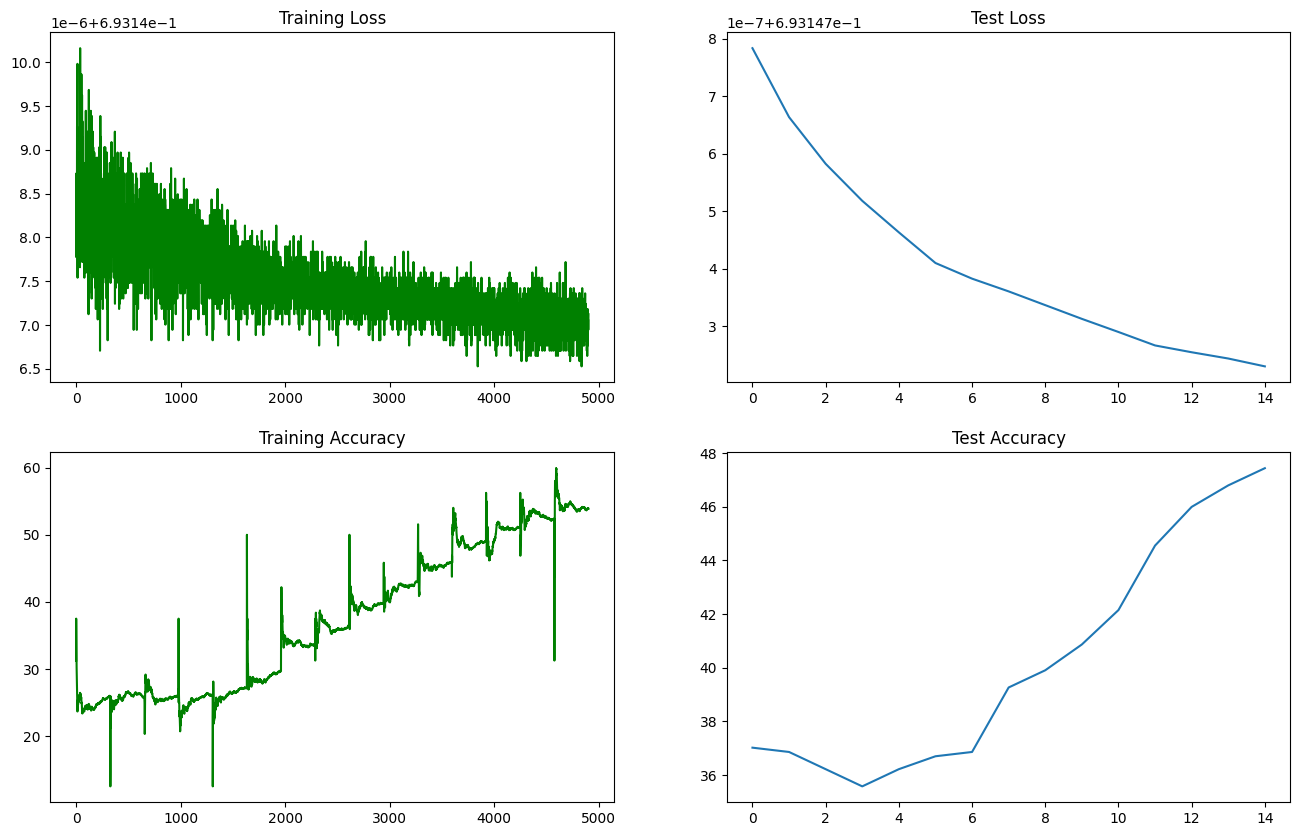

In [35]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")
plt.show()